In [1]:
!pip install aif360

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 2.7 MB/s eta 0:00:00


In [2]:
!pip install holisticai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 362.6/362.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 12.4 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

from holisticai.bias.plots import group_pie_plot
from holisticai.bias.plots import histogram_plot
from holisticai.bias.plots import frequency_matrix_plot
from holisticai.bias.plots import frequency_plot

from aif360.sklearn.datasets import fetch_adult
from aif360.sklearn.metrics import statistical_parity_difference
from aif360.sklearn.metrics import disparate_impact_ratio
from aif360.sklearn.preprocessing import ReweighingMeta
from aif360.sklearn.preprocessing import Reweighing

pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'
pip install 'aif360[OptimalTransport]'


## Lectura de datos

In [4]:
#Cargamos los datos y los dividimos en conjuntos de entrada y salida

datos = fetch_adult()
input = datos.X
output = datos.y

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Análisis de los datos

<Axes: >

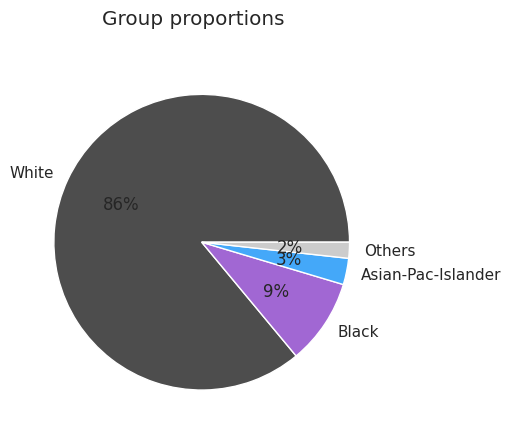

In [5]:
group_pie_plot(input['race'])

<Axes: >

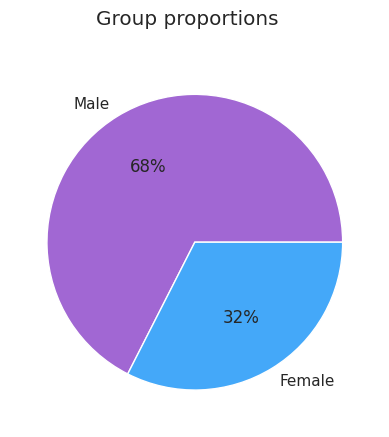

In [6]:
group_pie_plot(input['sex'])

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

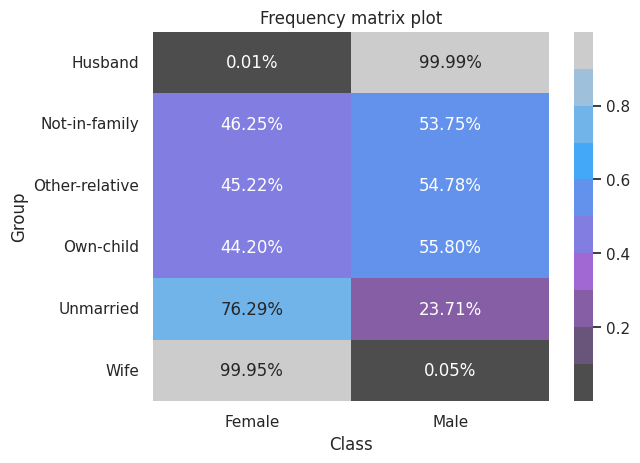

In [7]:
frequency_matrix_plot(input['relationship'], input['sex'], normalize='group')

<Axes: title={'center': 'Frequency matrix plot'}, xlabel='Class', ylabel='Group'>

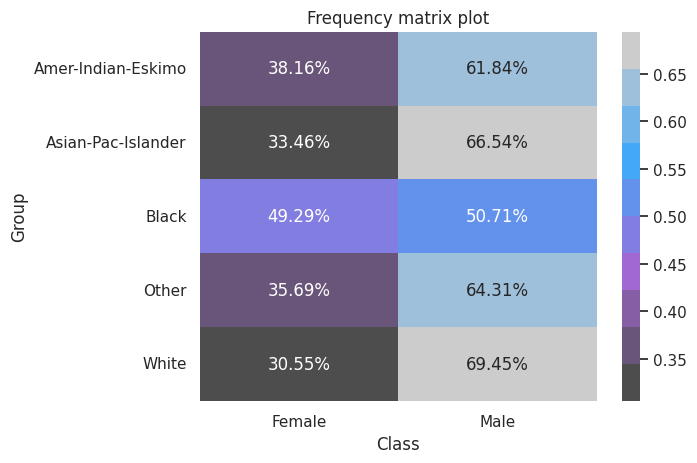

In [8]:
frequency_matrix_plot(input['race'], input['sex'], normalize='group')

## Procesado de datos

In [ ]:
#Codificamos los atributos protegidos

input.index = pd.MultiIndex.from_arrays(input.index.codes, names=input.index.names)
output.index = pd.MultiIndex.from_arrays(output.index.codes, names=output.index.names)

#Codificamos los valores de las columnas categoricas tanto en el input como en el output

le = LabelEncoder()
le2 = LabelEncoder()

for columna in input.columns:
  if input[columna].dtype != 'float64':
    input[columna] = le.fit_transform(input[columna])

output = pd.Series(le2.fit_transform(output), index=output.index)

#Dividimos los datos en conjuntos de entrenamiento y test
x_train, x_test, y_train, y_test = train_test_split(input, output, test_size=0.2, random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Experimento 1 (asumimos que todas las clases son igual de importantes)



In [ ]:
modelo = RandomForestClassifier(random_state=42)
modelo.fit(x_train, y_train)
y_pred = modelo.predict(x_test)

precision1 = accuracy_score(y_test, y_pred) * 100

spd1_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd1_raza = statistical_parity_difference(y_test, y_pred, prot_attr='race')

dpr1_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr1_raza = disparate_impact_ratio(y_test, y_pred, prot_attr='race')

print("Precision del modelo: {:.2f}%".format(precision1))

print("Statistical Parity Difference sexo: {:.5f}".format(spd1_sexo))
print("Statistical Parity Difference raza: {:.5f}".format(spd1_raza))

print("Disparate Impact Ratio sexo: {:.5f}".format(dpr1_sexo))
print("Disparate Impact Ratio raza: {:.5f}".format(dpr1_raza))

Precision del modelo: 84.68%
Statistical Parity Difference sexo: -0.16730
Statistical Parity Difference raza: -0.08327
Disparate Impact Ratio sexo: 0.35826
Disparate Impact Ratio raza: 0.61820


## Experimento 2 (reasignamos pesos con *sklearn*)



In [ ]:
class_weights = compute_class_weight(class_weight = 'balanced', classes = np.unique(y_train), y = y_train)
pesos_pixeles = np.zeros(y_train.shape)
for i, tag in enumerate(y_train):
  if tag==0:
    pesos_pixeles[i] = class_weights[0]
  else:
    pesos_pixeles[i] = class_weights[1]

In [ ]:
model2 = RandomForestClassifier()
model2.fit(x_train, y_train, sample_weight=pesos_pixeles)

y_pred = model2.predict(x_test)

precision2 = accuracy_score(y_pred, y_test)*100

spd2_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd2_raza = statistical_parity_difference(y_test, y_pred, prot_attr='race')

dpr2_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr2_raza = disparate_impact_ratio(y_test, y_pred, prot_attr='race')

print("Model accuracy: {:.2f} %".format(precision2))

print("Statistical Parity Difference contando el sexo: {:.5f}".format(spd2_sexo))
print("Statistical Parity Difference contando la raza: {:.5f}".format(spd2_raza))

print("Disparate Impact Ratio contando el sexo: {:.5f}".format(dpr2_sexo))
print("Disparate Impact Ratio contando la raza: {:.5f}".format(dpr2_raza))

Model accuracy: 84.42 %
Statistical Parity Difference contando el sexo: -0.19381
Statistical Parity Difference contando la raza: -0.10941
Disparate Impact Ratio contando el sexo: 0.32277
Disparate Impact Ratio contando la raza: 0.54150


## Experimento 3 (reasignamos pesos mediante preprocesamiento con *Reweighing*)



In [ ]:
rew = ReweighingMeta(estimator=RandomForestClassifier(),
                     reweigher=Reweighing())

params = {'estimator__n_estimators': [100, 300, 500, 700]}

model3 = GridSearchCV(estimator=rew, param_grid=params, scoring='accuracy')
model3.fit(x_train, y_train)

y_pred = model3.predict(x_test)

precision3 = accuracy_score(y_pred, y_test)*100

spd3_sexo = statistical_parity_difference(y_test, y_pred, prot_attr='sex')
spd3_raza = statistical_parity_difference(y_test, y_pred, prot_attr='race')

dpr3_sexo = disparate_impact_ratio(y_test, y_pred, prot_attr='sex')
dpr3_raza = disparate_impact_ratio(y_test, y_pred, prot_attr='race')

print("Model accuracy: {:.2f} %".format(precision3))
print("Statistical Parity Difference contando el sexo: {:.5f}".format(spd3_sexo))
print("Statistical Parity Difference contando la raza: {:.5f}".format(spd3_raza))

print("Disparate Impact Ratio contando el sexo: {:.5f}".format(dpr3_sexo))
print("Disparate Impact Ratio contando la raza: {:.5f}".format(dpr3_raza))

Model accuracy: 84.60 %
Statistical Parity Difference contando el sexo: -0.15924
Statistical Parity Difference contando la raza: -0.07853
Disparate Impact Ratio contando el sexo: 0.37309
Disparate Impact Ratio contando la raza: 0.63194


In [ ]:
resultados_metricas = pd.DataFrame()

resultados_metricas['Experimento 1'] = [precision1, spd1_sexo, spd1_raza, dpr1_sexo, dpr1_raza]
resultados_metricas['Experimento 2'] = [precision2, spd2_sexo, spd2_raza, dpr2_sexo, dpr2_raza]
resultados_metricas['Experimento 3'] = [precision3, spd3_sexo, spd3_raza, dpr3_sexo, dpr3_raza]

resultados_metricas.set_index(pd.Series(['Precision modelo (en %)',
                                         'Statistical Parity Difference sexo',
                                         'Statistical Parity Difference raza',
                                         'Disparate Impact Ratio sexo',
                                         'Disparate Impact Ratio raza']), inplace=True)
resultados_metricas

,Experimento 1,Experimento 2,Experimento 3
Precision modelo (en %),84.676617,84.422333,84.599226
Statistical Parity Difference sexo,-0.167302,-0.193810,-0.159236
Statistical Parity Difference raza,-0.083273,-0.109407,-0.078529
Disparate Impact Ratio sexo,0.358257,0.322771,0.373090
Disparate Impact Ratio raza,0.618196,0.541502,0.631941
